In [1]:
import drjit as dr
import mitsuba as mi
import imageio
from pathlib import Path

mi.set_variant('cuda_ad_rgb')

def generate_lowres_animation(scene: mi.Scene):
    import numpy as np

    images_lowres = []
    for i, scale in enumerate([1, 2, 4, 8, 16, 32, 64]):
        sensor_dict = mi.cornell_box()['sensor']
        sensor_dict['film']['rfilter']['type'] = 'box'
        sensor_dict['film']['width'] = sensor_dict['film']['width'] // scale 
        sensor_dict['film']['height'] = sensor_dict['film']['height'] // scale
        sensor: mi.Sensor = mi.load_dict(sensor_dict)

        image_lowres = mi.render(scene, sensor=sensor, spp=256)

        # Upscale the low-resolution image to the original size (nearest neighbor upsampling for pixel look)
        image_lowres_upsampled = np.repeat(np.repeat(image_lowres, (scale,), axis=0), (scale,), axis=1)
        images_lowres.append(mi.util.convert_to_bitmap(image_lowres_upsampled))

    return images_lowres

In [2]:
def cornell_box():
    scene_dict = mi.cornell_box()
    scene_dict['light']['emitter']['radiance']['value'] = [1.5*v for v in scene_dict['light']['emitter']['radiance']['value']]
    return scene_dict

scene = mi.load_dict(cornell_box())

In [3]:
image_ref = mi.render(scene, spp=512)

mi.util.write_bitmap(f"out/cornell/image_ref.png", image_ref)

images_lowres = generate_lowres_animation(scene)
imageio.mimwrite("out/cornell/image_ref_lowres.gif", images_lowres, fps=6)
mi.util.write_bitmap("out/cornell/image_ref_lowres.png", images_lowres[-1])

# Preview the reference image
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [4]:
class MyNull(mi.BSDF):
    def __init__(self, props):
        mi.BSDF.__init__(self, props)

    def sample(self, ctx: mi.BSDFContext, si: mi.SurfaceInteraction3f, 
                     sample1 :mi.Float, sample2 :mi.Point2f, mask: mi.Mask):
        bs = dr.zeros(mi.BSDFSample3f)
        bs.wo                = -si.wi
        bs.sampled_component = 0
        bs.sampled_type      = mi.UInt32(+mi.BSDFFlags.Null)
        bs.eta               = 1.
        bs.pdf               = 1.

        return (bs, dr.ones(mi.Color3f))

    def eval(self, *args, **kwargs):
        return dr.zeros(mi.Color3f)

    def pdf(self, *args, **kwargs):
        return 0.

    def eval_null_transmission(self, *args, **kwargs):
        return 1.

    def eval_pdf(self, *args, **kwargs):
        return (dr.zeros(mi.Color3f), 0.)

    def to_string(self, *args, **kwargs):
        return "MyNull[]"

mi.register_bsdf("mynull", MyNull)

# Render the (open) side-view
scene_dict = cornell_box()
green_bsdf = scene_dict['green'].copy()
scene_dict['green'] = {
    'type': 'twosided',
    'bsdf1': green_bsdf,
    'bsdf2': {
        'type': 'mynull'
    }
}

scene_dict['sensor']['to_world'] = mi.ScalarTransform4f().look_at(
    origin=[4, 0, 0],
    target=[0, 0, 0],
    up=[0, 1, 0]
)
scene_dict['sensor']['film']['height'] *= 4
scene_dict['sensor']['film']['width'] *= 4
scene_dict['sensor']['film']['pixel_format'] = 'rgba'
#scene_dict['constant'] = {'type': 'constant', 'radiance': {'type': 'rgb', 'value': 0.5}}

scene_open_side = mi.load_dict(scene_dict)

image_open_side = mi.render(scene_open_side, spp=256)
mi.Bitmap(image_open_side).convert(mi.Bitmap.PixelFormat.RGBA,
                                   mi.Struct.Type.UInt8, True).write("out/cornell/open_side.png")

In [5]:
params = mi.traverse(scene)

keys = [
    'red.reflectance.value',
    'green.reflectance.value'
]

# Save the original value
params_ref = {key: mi.Color3f(params[key]) for key in keys}

# Set another color value and update the scene
for key in keys:
    params[key] = mi.Color3f(0.5, 0.5, 0.5)
_ = params.update()

In [6]:
image_init = mi.render(scene, spp=128)

imageio.mimwrite("out/cornell/image_init_lowres.mp4", generate_lowres_animation(scene), fps=6)

mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [7]:
opt = mi.ad.Adam(lr=0.0075)
for key in keys:
    opt[key] = params[key]
_ = params.update(opt)

In [8]:
def mse(image):
    return dr.mean(dr.square(image - image_ref))

In [9]:
fps      = 30
duration = 4
iteration_count = fps*duration

In [10]:
errors = []
for it in range(iteration_count):
    # Perform a (noisy) differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)
    
    # Evaluate the objective function from the current rendered image
    loss = mse(image)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    for key in keys:
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)
    
    # Track the difference between the current color and the true value
    err_ref = 0
    for key in keys:
        err_ref += dr.sum(dr.square(params_ref[key] - params[key]))
    print(f"Iteration {it:02d}: parameter error = {err_ref}", end='\r')
    errors.append(dr.slice(err_ref))

    # Output the state after each iteration (re-render with higher spp)
    with dr.suspend_grad():
        image_highres = mi.render(scene, params, spp=512, seed=it) 
        mi.util.write_bitmap(f"out/cornell/image_{it:03d}.png", image_highres)

print('\nOptimization complete.')

Iteration 119: parameter error = [0.000463646]
Optimization complete.


## Results

We can now render the scene again to check whether the optimization process successfully recovered the color of the red wall.

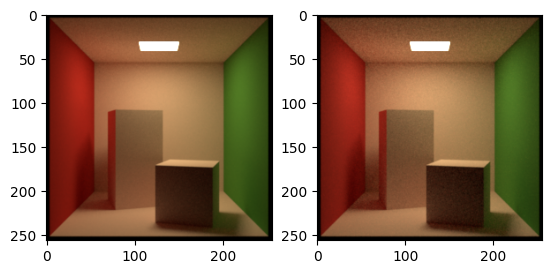

In [11]:
import matplotlib.pyplot as plt
image_final = mi.render(scene, spp=128)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(mi.util.convert_to_bitmap(image_ref))
axs[1].imshow(mi.util.convert_to_bitmap(image_final))

It worked!

Note visualizing the objective value directly sometimes gives limited information, since differences between `image` and `image_ref` can be dominated by Monte Carlo noise that is not related to the parameter being optimized. 

Since we know the “true” target parameter in this scene, we can validate the convergence of the optimization by checking the difference to the true color at each iteration:

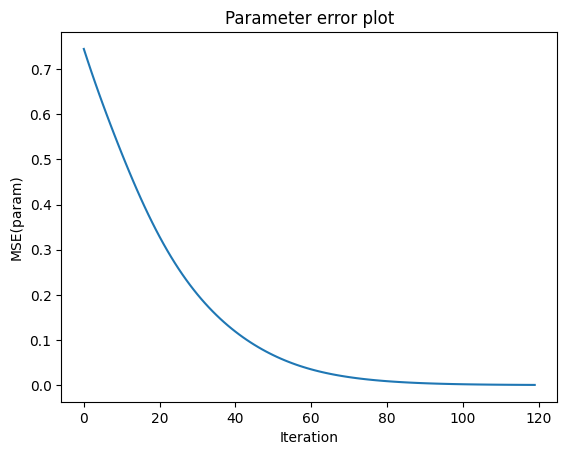

In [12]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('Iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');
plt.show()

## See also

- [Detailed look at <code>Optimizer</code>](https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/use_optimizers.html)
- API reference:
  - [<code>mitsuba.ad.Optimizer</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Optimizer)
  - [<code>prb</code> plugin](https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#path-replay-backpropagation-prb)
  - [<code>mitsuba.ad.SGD</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.SGD)
  - [<code>mitsuba.ad.Adam</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Adam)
  - [<code>drjit.backward</code>](https://drjit.readthedocs.io/en/latest/reference.html#drjit.backward)